# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [1]:
!apt-get update && apt-get install -y python3-opencv

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]   
Fetched 252 kB in 2s (133 kB/s)    
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 78 not upgraded.


In [2]:
!pip install sklearn

In [3]:
!pip install pandas

In [4]:
!pip install wandb

In [5]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import albumentations as A
import albumentations.pytorch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid

In [6]:
# import wandb
# wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: juyeonn (use `wandb login --relogin` to force relogin)


True

## Set Arguments & hyperparameters

In [7]:
# 시드(seed) 설정
# 실험을 동일하게 진행하기 위해서 동일한 난수의 사용이 필요 -> 시드 고정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED) # random seed를 고정하기 위한 함수 

# Nondeterministic 한 작업 피하기
# Nondeterministic = 비결정론적 = 동일한 입력이 주어지더라도 매번 다른 과정을 거쳐 다른 결과를 도출
# cudnn = 딥러닝에 특화된 CUDA library
torch.backends.cudnn.deterministic = True # Deterministic 한 알고리즘만 사용 # Deterministic = 결정론적 =  어떤 입력이 들어오면 언제나 똑같은 과정을 거쳐서 언제나 똑같은 결과
# cudnn은 convolution을 수행하는 과정에 벤치마킹을 통해서 지금 환경에 가장 적합한 알고리즘을 선정해 수행한다고 함,
# 이 과정에서 다른 알고리즘이 선정되면 연산 후 값이 달라질 수 있기 때문에 False로 설정
torch.backends.cudnn.benchmark = False 
np.random.seed(RANDOM_SEED) # 넘파이 시드 고정
random.seed(RANDOM_SEED)

In [8]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2 # binary classification

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 50
INPUT_SHAPE = 256


os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0번 gpu 사용 (특정 gpu 지정)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device에 cuda (GPU)를 설정

In [9]:
# wandb config 모델의 하이퍼파라미터, 데이터명 등 학습에 필요한 구성들을 그룹화
config = {
    'epochs': 100,
    'classes': 2,
    'batch_size': 32,
    'learning late': 0.0005, # 3배씩 늘린다 0.001
    'early_stopping_patience': 50,
    'input_shape': 256,
    'architecture': 'vgg16'
}

## Dataloader

#### Train & Validation Set loader

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        # 이미지를 input_shape로 Resize하고, Tensor화, Normalize하는 함수 
        # Albumentation 적용전
         '''
            if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(30)
                ]),
                transforms.Resize(self.input_shape),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]) 
        elif self.mode == 'val':
            self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        else:
            print(f'!!! Invalid transform {self.mode}... !!!')
            '''
        
        # Albumentation 적용후
        # RandomHorizontalFlip, RandomVerticalFlip 과 같은 augmentation은 CT사진에는 성능개선에 크게 영향을 주지 못하였기 때문에 제외 시킨후
        # CLAHE, Blur, Cutout등 다른 요소들을 고려하여 Albumentation으로 augmentation을 진행하였더니 속도도 더 빠르고, 모델 성능도 올라가게 되었다.
        if self.mode == 'train':
            self.transform = A.Compose([
                                    A.Resize(self.input_shape, self.input_shape),
                                    A.OneOf([
                                        A.Blur(blur_limit=7, always_apply=False, p=0.5),
                                        A.CLAHE(clip_limit=5.0, always_apply=False, p=0.5),
                                    ],p=0.5),
                                    A.OneOf([
                                        A.Cutout(num_holes=8, max_h_size=15, max_w_size=15, fill_value=0, always_apply=False, p=0.5),
                                        A.Rotate(always_apply=False, p=0.3),
                                        A.ToSepia(always_apply=False, p=0.2),
                                    ],p=0.5),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    A.pytorch.transforms.ToTensorV2()
                                ])
            
        elif self.mode == 'val':
            self.transform = A.Compose([
                                    A.Resize(self.input_shape, self.input_shape),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    A.pytorch.transforms.ToTensorV2()
                                ])
        else:
            print(f'!!! Invalid transform {self.mode}... !!!')
 

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir): # 폴더가 없으면 
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit() # 프로그램 중단 
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv')) # os.path.join() = 인수에 전달된 2개의 문자열을 결합하여, 1개의 경로로 만드는 함수 
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index): # 각 데이터의 이미지 텐서, 라벨값 리턴
        data = copy.deepcopy(self.db.loc[index]) # db의 index row를 깊은 복사 

        # Loading image
        # cv2.imread(filename, flag) = 이미지 읽어오는 함수 filename: 이미지 경로, flag: 이미지 파일 읽을 때 option -> return type: numpy.ndarray
        # cv2.IMREAD_COLOR: 이미지 파일을 Color로 읽어들임, 투명한 부분은 무시
        # cv2.IMREAD_IGNORE_ORIENTATION: EXIF에 저장된 방향 정보를 사용하지 않음
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray): # cvimg의 np.ndarray가 int형이 아니면 
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images 이미지 전처리 
        transformed = self.transform(image=cvimg)
        trans_image = transformed["image"]


        return trans_image, data['COVID']


## Model

In [13]:
# import torch.nn.functional as F

In [14]:
#Model 정의
class vgg16(nn.Module):
    def __init__(self, num_classes):
        super(vgg16, self).__init__()
        self.model = models.vgg16(pretrained=False,num_classes=num_classes)
        self.softmax = nn.Softmax(dim=1) 

    
    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

## Utils
### EarlyStopper

In [15]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [16]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer # 최적화 
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader): # enumerate: 인덱스와 값이 함께 출력 
            img = img.to(self.device) # gpu에 올리기
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad() # gradients를 zero로 만들어줌 
            loss.backward() #  gradient 계산, 역전파 단계 
            self.optimizer.step() # 매개변수 갱신
            self.scheduler.step() # 학습률 스케쥴러 학습과정에서 learning rate를 조정하는 learning rate scheduler
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist()) # iterable 자료형의 항목 각각을 array의 끝에 하나씩 추가 
                                                      # iterable: member를 하나씩 차례로 반환 가능한 object, 예로는 list, str, tuple 
                                                      # cpu(): GPU 메모리에 올려져 있는 tensor를 cpu 메모리로 복사하는 method
                                                      
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist()) # argmax: arguments of the maxima 차원에 따라 가장 큰 값의 인덱스들을 반환해주는 함수 
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [17]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [18]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [20]:
# 이미지를 보여주는 함수
def show_batch(image):
    for images, labels in image:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


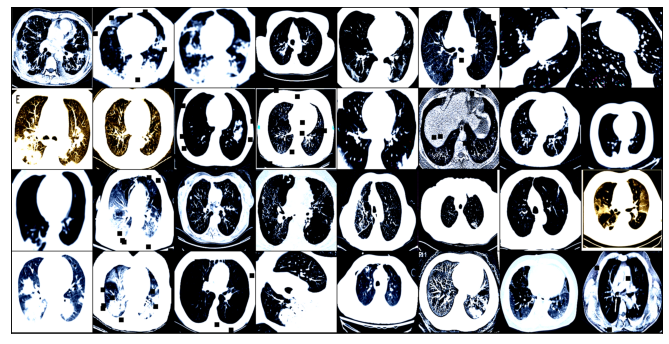

In [21]:
show_batch(train_dataloader)

#### Load model and other utils

In [22]:
# Load Model
model = vgg16(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# OneCycleLR: 초기 learing rate에서 1cycle annealing하는 scheduler
# 1주기 전략은 초기 learning rate에서 최대 learning rate까지 올라간 후 초기 learning rate보다 훨씬 낮은 learning rate로 annealing함 
# pct_start: learning rate를 언제까지 증가시킬지 epoch에 대한 비율로 나타냄
# div_factor: initial_lr = max_lr/div_factor 로 lr 초기화 
# max_lr: 최대 lr
# steps_per_epoch: epoch당 step수
scheduler =  optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
# BCELoss에서는 CrossEntropyLoss와 같이 softmax를 포함한 것이 아닌, Cross Entropy만 구함
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [23]:
model

vgg16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

### epoch 단위 학습 진행

In [ ]:
# wandb.init(project='Image Augmentation', name='vgg16', config=config)
# wandb.watch(model, metric_fn, log='all', log_freq=10)

# tqdm: 진행상황을 제공하는 라이브러리
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)
    
    # wandb.log({"train_loss": trainer.train_mean_loss}, step=epoch_index)
    # wandb.log({"train_score": trainer.train_score}, step=epoch_index)
    # wandb.log({"val_loss": trainer.val_mean_loss}, step=epoch_index)
    # wandb.log({"val_score": trainer.validation_score}, step=epoch_index)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(), # 모델의 실제 내용 (가중치, 양자화 방법, 옵티마이저 등)을 저장
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')

# wandb.finish()

  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7285031212700738, Acc: 0.49569707401032703, F1-Macro: 0.4673644029348728


  3% 1/30 [00:30<14:48, 30.62s/it]

Epoch 0, Val loss: 1.1972378492355347, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Epoch 1, Train loss: 0.7258248858981662, Acc: 0.5507745266781411, F1-Macro: 0.49947683725842923
Epoch 1, Val loss: 0.9602192342281342, Acc: 0.5230769230769231, F1-Macro: 0.39398496240601505
Validation loss decreased 1.1972378492355347 -> 0.9602192342281342


  7% 2/30 [01:12<15:48, 33.87s/it]

Epoch 2, Train loss: 0.7064330710305108, Acc: 0.5559380378657487, F1-Macro: 0.5343857164156851
Epoch 2, Val loss: 1.3742616772651672, Acc: 0.5384615384615384, F1-Macro: 0.4422196796338673
Early stopping counter 1/10


 10% 3/30 [01:53<16:17, 36.19s/it]

Epoch 3, Train loss: 0.7288307812478807, Acc: 0.5301204819277109, F1-Macro: 0.5293173286644806
Epoch 3, Val loss: 1.0086942315101624, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 2/10


 13% 4/30 [02:35<16:24, 37.88s/it]

Epoch 4, Train loss: 0.6935352550612556, Acc: 0.5869191049913941, F1-Macro: 0.5170407315045719
Epoch 4, Val loss: 0.9521672129631042, Acc: 0.7076923076923077, F1-Macro: 0.7051802339460491
Validation loss decreased 0.9602192342281342 -> 0.9521672129631042


 17% 5/30 [03:24<17:10, 41.24s/it]

Epoch 5, Train loss: 0.6822569717963537, Acc: 0.6368330464716007, F1-Macro: 0.6366780571221959
Epoch 5, Val loss: 1.226413607597351, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 1/10


 20% 6/30 [04:17<17:51, 44.63s/it]

Epoch 6, Train loss: 0.6644962148533927, Acc: 0.6712564543889845, F1-Macro: 0.670596791189872
Epoch 6, Val loss: 0.6934038624167442, Acc: 0.6923076923076923, F1-Macro: 0.6794871794871795
Validation loss decreased 0.9521672129631042 -> 0.6934038624167442


## Inference
### 모델 로드

In [ ]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = A.Compose([
                                    A.Resize(self.input_shape, self.input_shape),
                                    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    A.pytorch.transforms.ToTensorV2()
                                ])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        transformed = self.transform(image=cvimg)
        trans_image = transformed["image"]

        return trans_image, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model']) # 저장된 모델을 로드

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval() # evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
# test 때는 gradient를 안해도 되니까 no_grad
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

### 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('vgg16_ver2.csv', index=False)